In [31]:
import torch
import scvelo as scv
import numpy as np
import scanpy as sc

In [35]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (7, 7)
mpl.rcParams['figure.dpi'] = 100

In [2]:
from autoencoder import Autoencoder

In [3]:
def train_autoencoder(X, autoencoder, lr, batch_size, num_epochs, optim = torch.optim.Adam, **kwargs):
    optimizer = optim(autoencoder.parameters(), lr=lr, **kwargs)
    
    l2_loss = torch.nn.MSELoss(reduction='sum')
    
    n_obs = X.shape[0]
    
    t_X = torch.from_numpy(X)
    
    for epoch in range(num_epochs):
        autoencoder.train()
        
        for step in range(int(n_obs/batch_size)):
            batch = t_X[np.random.choice(n_obs, batch_size)]
            
            encoded, decoded = autoencoder(batch)
            
            loss = l2_loss(decoded, batch)/batch_size
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        autoencoder.eval()
        
        t_encoded, t_decoded = autoencoder(t_X)
        t_loss = l2_loss(t_decoded, t_X).data.numpy()/n_obs
        
        print('Epoch:', epoch, '-- total train loss: %.4f' % t_loss)

In [4]:
adata = scv.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [5]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


In [6]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [7]:
adata.obsm['X_and_velocity'] = np.hstack((adata.X.toarray(), adata.layers['velocity']))

In [8]:
autoencoder = Autoencoder(adata.n_vars, 100)

In [9]:
LR = 0.005
BATCH_SIZE = 40
N_EPOCHS = 50

In [10]:
train_autoencoder(adata.X.toarray(), autoencoder, LR, BATCH_SIZE, N_EPOCHS)

Epoch: 0 -- total train loss: 270.3409
Epoch: 1 -- total train loss: 240.6496
Epoch: 2 -- total train loss: 238.6537
Epoch: 3 -- total train loss: 230.5664
Epoch: 4 -- total train loss: 228.6631
Epoch: 5 -- total train loss: 226.0931
Epoch: 6 -- total train loss: 223.5110
Epoch: 7 -- total train loss: 219.9653
Epoch: 8 -- total train loss: 217.9494
Epoch: 9 -- total train loss: 215.1238
Epoch: 10 -- total train loss: 215.2514
Epoch: 11 -- total train loss: 210.3262
Epoch: 12 -- total train loss: 208.3158
Epoch: 13 -- total train loss: 207.1194
Epoch: 14 -- total train loss: 206.1473
Epoch: 15 -- total train loss: 205.4877
Epoch: 16 -- total train loss: 206.7800
Epoch: 17 -- total train loss: 204.2112
Epoch: 18 -- total train loss: 204.6959
Epoch: 19 -- total train loss: 202.6931
Epoch: 20 -- total train loss: 202.7129
Epoch: 21 -- total train loss: 202.4855
Epoch: 22 -- total train loss: 201.8141
Epoch: 23 -- total train loss: 201.4882
Epoch: 24 -- total train loss: 200.9402
Epoch: 25 

In [11]:
encoded, decoded = autoencoder(torch.from_numpy(adata.X.toarray()))

In [12]:
adata.obsm['X_enc'] = encoded.data.numpy()

In [19]:
autoencoder = Autoencoder(adata.n_vars, 100)

In [20]:
train_autoencoder(adata.layers['velocity'], autoencoder, LR, BATCH_SIZE, N_EPOCHS)

Epoch: 0 -- total train loss: 74.7193
Epoch: 1 -- total train loss: 64.5702
Epoch: 2 -- total train loss: 59.3327
Epoch: 3 -- total train loss: 54.4785
Epoch: 4 -- total train loss: 50.1504
Epoch: 5 -- total train loss: 47.7108
Epoch: 6 -- total train loss: 46.7150
Epoch: 7 -- total train loss: 50.9648
Epoch: 8 -- total train loss: 46.6020
Epoch: 9 -- total train loss: 46.7226
Epoch: 10 -- total train loss: 44.9843
Epoch: 11 -- total train loss: 41.8886
Epoch: 12 -- total train loss: 42.7844
Epoch: 13 -- total train loss: 40.0581
Epoch: 14 -- total train loss: 40.8813
Epoch: 15 -- total train loss: 38.2618
Epoch: 16 -- total train loss: 40.0881
Epoch: 17 -- total train loss: 37.0938
Epoch: 18 -- total train loss: 38.2241
Epoch: 19 -- total train loss: 37.4747
Epoch: 20 -- total train loss: 36.6411
Epoch: 21 -- total train loss: 36.1179
Epoch: 22 -- total train loss: 35.9566
Epoch: 23 -- total train loss: 36.1233
Epoch: 24 -- total train loss: 33.6624
Epoch: 25 -- total train loss: 35.2

In [21]:
encoded, decoded = autoencoder(torch.from_numpy(adata.layers['velocity']))

In [22]:
adata.obsm['Vel_enc'] = encoded.data.numpy()

In [27]:
n_vars = adata.obsm['X_and_velocity'].shape[1]
autoencoder = Autoencoder(n_vars, 100)

In [28]:
train_autoencoder(adata.obsm['X_and_velocity'], autoencoder, LR, BATCH_SIZE, N_EPOCHS)

Epoch: 0 -- total train loss: 379.1209
Epoch: 1 -- total train loss: 328.6772
Epoch: 2 -- total train loss: 316.4156
Epoch: 3 -- total train loss: 299.1390
Epoch: 4 -- total train loss: 289.4268
Epoch: 5 -- total train loss: 282.4880
Epoch: 6 -- total train loss: 278.0957
Epoch: 7 -- total train loss: 270.9341
Epoch: 8 -- total train loss: 267.7285
Epoch: 9 -- total train loss: 265.8130
Epoch: 10 -- total train loss: 262.2681
Epoch: 11 -- total train loss: 259.2873
Epoch: 12 -- total train loss: 258.7105
Epoch: 13 -- total train loss: 256.2922
Epoch: 14 -- total train loss: 256.1314
Epoch: 15 -- total train loss: 254.8497
Epoch: 16 -- total train loss: 252.9448
Epoch: 17 -- total train loss: 256.5568
Epoch: 18 -- total train loss: 250.6549
Epoch: 19 -- total train loss: 248.9757
Epoch: 20 -- total train loss: 248.9154
Epoch: 21 -- total train loss: 248.8736
Epoch: 22 -- total train loss: 253.6474
Epoch: 23 -- total train loss: 250.4978
Epoch: 24 -- total train loss: 246.3521
Epoch: 25 

In [29]:
encoded, decoded = autoencoder(torch.from_numpy(adata.obsm['X_and_velocity']))

In [30]:
adata.obsm['X_Vel_enc'] = encoded.data.numpy()

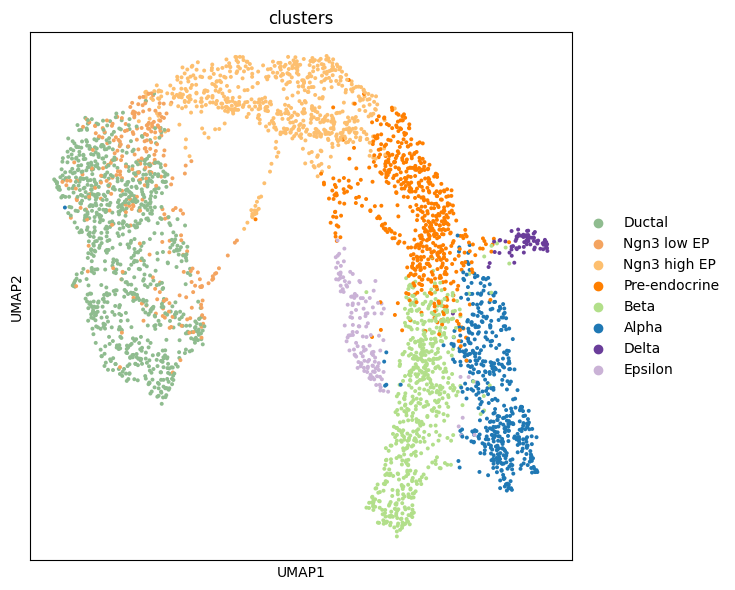

In [36]:
sc.pp.neighbors(adata, use_rep='X_enc')
sc.tl.umap(adata)
sc.pl.umap(adata, color='clusters')

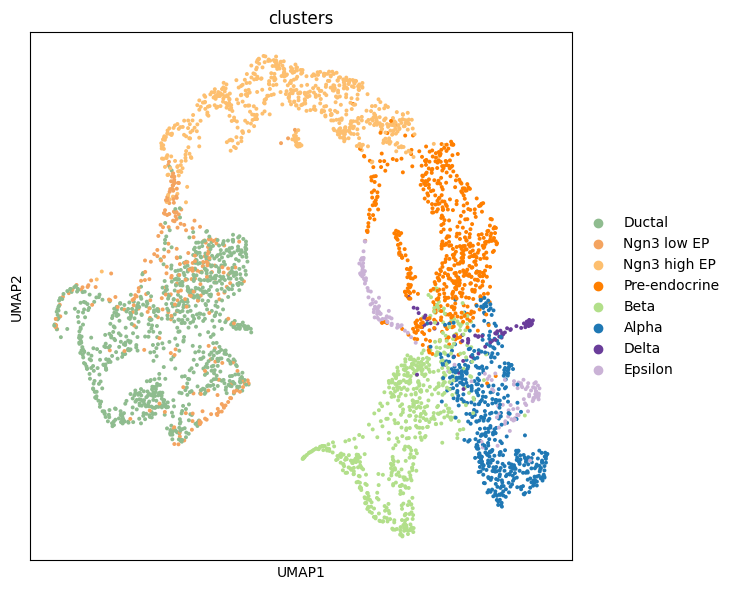

In [37]:
sc.pp.neighbors(adata, use_rep='Vel_enc')
sc.tl.umap(adata)
sc.pl.umap(adata, color='clusters')

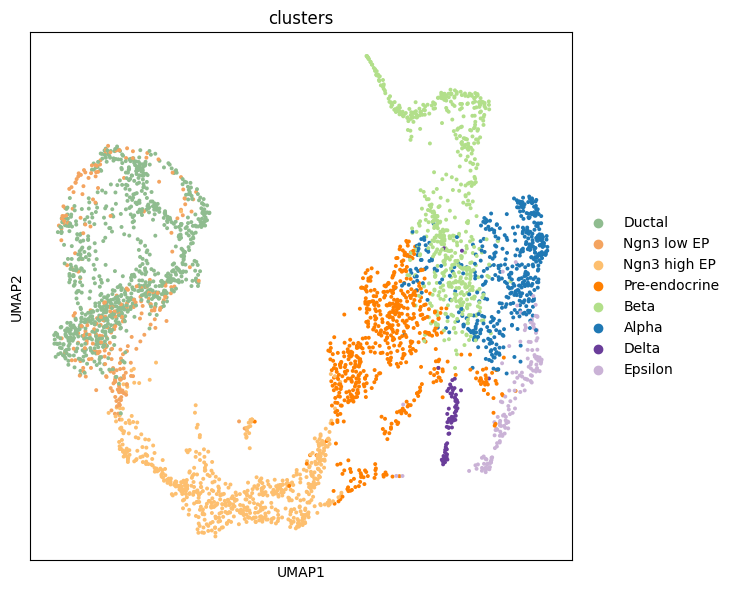

In [38]:
sc.pp.neighbors(adata, use_rep='X_and_velocity')
sc.tl.umap(adata)
sc.pl.umap(adata, color='clusters')

In [39]:
adata.write('pancreas_vels_aut.h5ad')